# Проект: "Телеком"

## Описание проекта 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- contract.csv — информация о договоре;
- personal.csv — персональные данные клиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


# План работы 

Перед нами стоит задача проанализировать данные и спрогнозировать отток пользователей.

- Описание данных. Выводы по этому пункту
- Исследование зависимостей и формулирование гипотез.
- Построение моделей для прогнозирования оттока.
- Задача достичь метрики ROC-AUC не меньше 0.85
- Проверка качества полученной модели на тестовой выборке.
- Подготовка отчета, итоговые выводы.

### Импортируем библиотеки и откроем файлы

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
!pip3 install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (precision_score, recall_score, accuracy_score, 
                             f1_score, confusion_matrix, roc_curve, 
                             roc_auc_score, ConfusionMatrixDisplay
                            )
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from datetime import datetime
from scipy import stats as st

import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
try:
  contract = pd.read_csv('/datasets/final_provider/contract.csv')
  internet = pd.read_csv('/datasets/final_provider/internet.csv')
  personal = pd.read_csv('/datasets/final_provider/personal.csv')
  phone = pd.read_csv('/datasets/final_provider/phone.csv')

except:
  contract = pd.read_csv('/content/contract.csv')
  internet = pd.read_csv('/content/internet.csv')
  personal = pd.read_csv('/content/personal.csv')
  phone = pd.read_csv('/content/phone.csv')

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


### Вывод по предварительному знакомству с данными:

- данные не имеют пропусков
- столбцы BeginDate и EndDate надо перевести в формат даты
- можно переименовать столбец customerID чтобы привести его к общему виду
- в столбце EndDate значение "No" - фактический пользоватуль услуг - это целевой признак
- столбец TotalCharges надо привести в числовой тип
- закодировать признаки применив One Hot Encoding.

# План
- Изучить данные в файлах - проверить типы, есть ли пропуски, надо ли преобразовывать данные
- Подготовить данные на основе выводов, полученных на предыдущем шаге
- Провести исследовательский анализ данных - вузализация данных, избавление от выбросов, масштабирование.
- Перебор моделей и подбор их параметров
- Выбор лучшей модели и проверка её на тесте с достижением метрики ROC-AUC не ниже 0.85.
- Вывод по итогам работы

# Исследовательский анализ данных 

Заменим типы данных и удалим неявные дубликаты.

In [ ]:
contract['customerID'] = contract['customerID'].str.lower()
contract['EndDate'] = contract['EndDate'].str.lower()
contract['Type'] = contract['Type'].str.lower()
contract['PaperlessBilling'] = contract['PaperlessBilling'].str.lower()
contract['PaymentMethod'] = contract['PaymentMethod'].str.lower()

In [ ]:
contract.loc[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-lvygi,2020-02-01,no,two year,yes,bank transfer (automatic),52.55,
753,3115-czmzd,2020-02-01,no,two year,no,mailed check,20.25,
936,5709-lvoeq,2020-02-01,no,two year,no,mailed check,80.85,
1082,4367-nuyao,2020-02-01,no,two year,no,mailed check,25.75,
1340,1371-dwpaz,2020-02-01,no,two year,no,credit card (automatic),56.05,
3331,7644-omvmy,2020-02-01,no,two year,no,mailed check,19.85,
3826,3213-vvolg,2020-02-01,no,two year,no,mailed check,25.35,
4380,2520-sgtta,2020-02-01,no,two year,no,mailed check,20.00,
5218,2923-arzlg,2020-02-01,no,one year,yes,mailed check,19.70,
6670,4075-wkniu,2020-02-01,no,two year,no,mailed check,73.35,


Заменим в столбце EndDate на дату выгрузки данных '2020-02-01'.

In [ ]:
contract.loc[contract['EndDate'] == 'no', 'EndDate'] = '2020-02-01'

Все пропущенные значения в TotalCharges появились в одну дату - 2020-02-01, заменим их на Nan и приведем столбец к типу float.

In [ ]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

BeginDate, EndDate приведем к типу datetime.

In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d %H:%M:%S')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

Приведем столбцы к нижнему регистру:

In [ ]:
for column in internet.columns:
    internet[column] = internet[column].str.lower()

In [ ]:
for column in ['customerID', 'gender', 'Partner', 'Dependents']:
    personal[column] = personal[column].str.lower()

In [ ]:
for column in phone.columns:
    phone[column] = phone[column].str.lower()

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


Создадим единый датасет:

In [ ]:
all_df = contract.merge(internet, on='customerID', how='left')
all_df = all_df.merge(personal, on='customerID', how='left')
all_df = all_df.merge(phone, on='customerID', how='left')

In [ ]:
print('Количество пропусков для столбцов из таблицы internet', all_df.loc[all_df['InternetService'].isna()].shape[0])
print('Количество пропусков для столбцов из таблицы phone', all_df.loc[all_df['MultipleLines'].isna()].shape[0])
print('Уникальных пользователей в объединенном датасете -', all_df['customerID'].nunique())
print('Размер полученного датасета', all_df.shape)

Количество пропусков для столбцов из таблицы internet 1526
Количество пропусков для столбцов из таблицы phone 682
Уникальных пользователей в объединенном датасете - 7043
Размер полученного датасета (7043, 20)


In [ ]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   InternetService   5517 non-null   object        
 9   OnlineSecurity    5517 non-null   object        
 10  OnlineBackup      5517 non-null   object        
 11  DeviceProtection  5517 non-null   object        
 12  TechSupport       5517 non-null   object        
 13  StreamingTV       5517 non-null   object        
 14  StreamingMovies   5517 n

In [ ]:
all_df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
customerID,7043,7043,7590-vhveg,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BeginDate,7043,77,2014-02-01 00:00:00,366,2013-10-01,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EndDate,7043,5,2020-02-01 00:00:00,5174,2019-10-01,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,7043,3,month-to-month,3875,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaperlessBilling,7043,2,yes,4171,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PaymentMethod,7043,4,electronic check,2365,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,7043.0,NaN,NaN,NaN,NaT,NaT,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75
TotalCharges,7032.0,NaN,NaN,NaN,NaT,NaT,2283.300441,2266.771362,18.8,401.45,1397.475,3794.7375,8684.8
InternetService,5517,2,fiber optic,3096,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,5517,2,no,3498,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Появились пропущенные значения в тех столбцах, где пользователи не использовали телефон или интеренет.

# Обработка пропущенных значений

In [ ]:
all_df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

In [ ]:
print('Количество клиентов оформивших договор на услуги 01-02-2020 - ', 
      all_df.loc[all_df['BeginDate'] == '2020-02-01'].shape[0])

Количество клиентов оформивших договор на услуги 01-02-2020 -  11


Заполним пропущенные значения в TotalCharges на значения столбца MonthlyCharges.

In [ ]:
print('Количество пользователей с одинаковым ежемесячным и общим платежем до изменений', 
      all_df.loc[all_df['MonthlyCharges'] == all_df['TotalCharges']].shape[0])

Количество пользователей с одинаковым ежемесячным и общим платежем до изменений 613


In [ ]:
all_df.loc[all_df['TotalCharges'].isna(), 'TotalCharges'] = all_df['MonthlyCharges']

In [ ]:
print('Количество пользователей с одинаковым месячным и общим платежем после изменений', 
      all_df.loc[all_df['MonthlyCharges'] == all_df['TotalCharges']].shape[0])

Количество пользователей с одинаковым месяынм и общим платежем после изменений 624


Обработаем пропущенные значения столбцов пользователей интренета:

In [ ]:
all_df[['InternetService', 'OnlineSecurity', 
          'OnlineBackup', 'DeviceProtection', 
          'TechSupport', 'StreamingTV', 
          'StreamingMovies']] = all_df[['InternetService', 'OnlineSecurity', 
                                                           'OnlineBackup', 'DeviceProtection',
                                                           'TechSupport', 'StreamingTV', 
                                                           'StreamingMovies']].fillna('no')

In [ ]:
all_df['MultipleLines'] = all_df['MultipleLines'].fillna('empty')

In [ ]:
print(all_df['InternetService'].unique())
print(all_df['MultipleLines'].unique())

['dsl' 'fiber optic' 'no']
['empty' 'no' 'yes']


In [ ]:
all_df['leave'] = 0
all_df.loc[all_df['EndDate'] < '2020-02-01', 'leave'] = 1
all_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,leave
0,7590-vhveg,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,29.85,dsl,no,...,no,no,no,no,female,0,yes,no,empty,0
1,5575-gnvde,2017-04-01,2020-02-01,one year,no,mailed check,56.95,1889.50,dsl,yes,...,yes,no,no,no,male,0,no,no,no,0
2,3668-qpybk,2019-10-01,2019-12-01,month-to-month,yes,mailed check,53.85,108.15,dsl,yes,...,no,no,no,no,male,0,no,no,no,1
3,7795-cfocw,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1840.75,dsl,yes,...,yes,yes,no,no,male,0,no,no,empty,0
4,9237-hqitu,2019-09-01,2019-11-01,month-to-month,yes,electronic check,70.70,151.65,fiber optic,no,...,no,no,no,no,female,0,no,no,no,1


Добавим столбец с количеством дней от регистрации договора до даты сбора датасета - 2020-02-01.

In [ ]:
all_df['duration'] = (datetime.strptime("2020-02-01", "%Y-%m-%d") - all_df['BeginDate']) // np.timedelta64(1, 'D') 

In [ ]:
all_df['delta'] = (all_df['EndDate'] - all_df['BeginDate']) // np.timedelta64(1, 'D') 

In [ ]:
for column in all_df.columns:
    print('Количество уникальных значений столбца', column, '', all_df[column].nunique())

Количество уникальных значений столбца customerID  7043
Количество уникальных значений столбца BeginDate  77
Количество уникальных значений столбца EndDate  5
Количество уникальных значений столбца Type  3
Количество уникальных значений столбца PaperlessBilling  2
Количество уникальных значений столбца PaymentMethod  4
Количество уникальных значений столбца MonthlyCharges  1585
Количество уникальных значений столбца TotalCharges  6534
Количество уникальных значений столбца InternetService  3
Количество уникальных значений столбца OnlineSecurity  2
Количество уникальных значений столбца OnlineBackup  2
Количество уникальных значений столбца DeviceProtection  2
Количество уникальных значений столбца TechSupport  2
Количество уникальных значений столбца StreamingTV  2
Количество уникальных значений столбца StreamingMovies  2
Количество уникальных значений столбца gender  2
Количество уникальных значений столбца SeniorCitizen  2
Количество уникальных значений столбца Partner  2
Количество 

Подготовим функции для построения графиков.

In [ ]:
def oneplot(df=all_df, title1='', xl='', yl='', height=3, width=15):
    
    fig, ax = plt.subplots()
    
    plt.rcParams['font.size'] = '12'
    
    ax.minorticks_on()
    
    line = sns.lineplot(data=df, palette='mako',linewidth=3, dashes=False)
    
    line.set_title(title1, fontdict={'fontsize': 14})
    line.set_ylabel(yl, fontdict={'fontsize': 12})
    line.set_xlabel(xl, fontdict={'fontsize': 12})
    
    plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    ax.grid(which='minor',color = 'lightblue', linewidth = 1, linestyle=':')
    
    fig.set_figheight(height)
    fig.set_figwidth(width)
    
    return line

In [ ]:
def barplot_sns(df, X, Y, title1='', xlabel1='', ylabel1='', rotation_x=0, figsize_1=(15, 5), h=None):    
    
    fig, ax = plt.subplots(figsize=figsize_1)
    
    bar = sns.barplot(data=df, x=X, y=Y, palette='Greens_d', hue=h)
    
    bar.set_title(title1, fontdict={'fontsize': 12})
    
    bar.set_xlabel(xlabel1, fontsize=12)
    bar.set_ylabel(ylabel1, fontsize=12)
    
    plt.grid(color = 'aquamarine', linewidth = 1, linestyle=':')
    
    plt.xticks(rotation=rotation_x)
    
    return bar

In [ ]:
def heatmap_b(df, title_1='Корреляция признаков', size=(15, 15)):
    plt.figure(figsize=size)

    matrix = np.triu(df.corr())
    
    heatmap_b = sns.heatmap((df.corr()), 
        vmin=-1, 
        vmax=1, 
        cmap="PuBuGn", 
        annot=True, 
        fmt='.2g', mask=matrix, annot_kws={'fontsize':12})


    heatmap_b.set_title(title_1, fontdict={'fontsize':12})

    return heatmap_b

In [ ]:
def kdeplot(data, xlabel1='',
                 figsize_1=(15, 5), label1='', suptitle1='', ylabel1='', lg='', hue1=None):
    
    fig, ax = plt.subplots(figsize=figsize_1)

    fig.suptitle(suptitle1, fontsize=14)

    kdeplot_t = sns.kdeplot(data, color='skyblue', 
                            alpha=.4, shade=True, label=label1, hue=hue1) 

    kdeplot_t.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    
    kdeplot_t.set_xlabel(xlabel1, fontsize=12)
    kdeplot_t.set_ylabel(ylabel1, fontsize=12)
        
    return kdeplot_t

Рассмотрим через какое количество дней, в среднем, клиенты уходят:

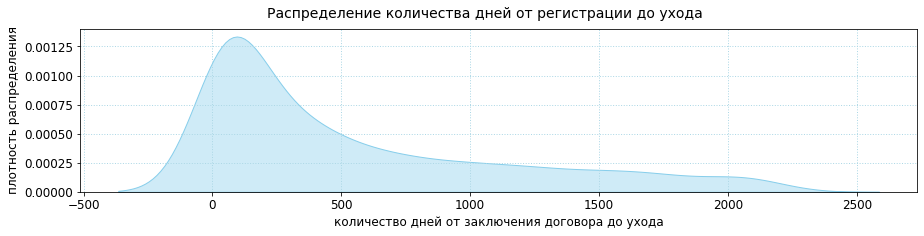

In [ ]:
kdeplot(data=all_df.loc[all_df['leave'] > 0]['delta'], 
        xlabel1='количество дней от заключения договора до ухода', 
        figsize_1=(15, 3), 
        suptitle1='Распределение количества дней от регистрации до ухода', 
        ylabel1='плотность распределения', 
        lg='количество дней')
plt.show()

In [ ]:
all_df.loc[all_df['leave'] > 0]['delta'].describe().T

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: delta, dtype: float64

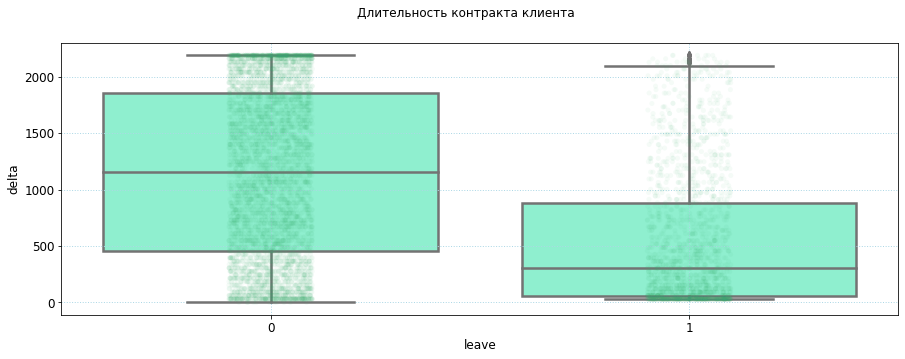

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
    
fig.suptitle('Длительность контракта клиента', fontsize=12)
       
sns.boxplot(x='leave', y='delta', data=all_df, color='aquamarine', linewidth=2.5)
sns.stripplot(x='leave', y='delta', data=all_df, marker="o", alpha=0.05, color="mediumseagreen")
        
plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')

Видно что в основном уходят новички.
Медианная длительность контракта у ушедших клиентов значительно ниже - около 300 дней, тогда как для оставшихся - около 1200.
Длительность контракта от 0 до > 2000 дней для всех групп, при этом расмах значений для ушедших клиентов в основном от 0 до 2000 дней.

В целом, чем дольше клиент пользуется услугами, тем с меньшей вероятностью уходит. До 50% пользователей уходят до года пользования услугами - около 304 дней.
В среднем - пользователи уходят спустя около 550, при этом высокое стандартное отклонение и разница между медианой и средним говорят о выбросах в данных, поэтому ориентироваться будем на медиану в 304 дня.

Рассмотрим распределение стоимости услуг для ушедших и оставшихся клиентов.

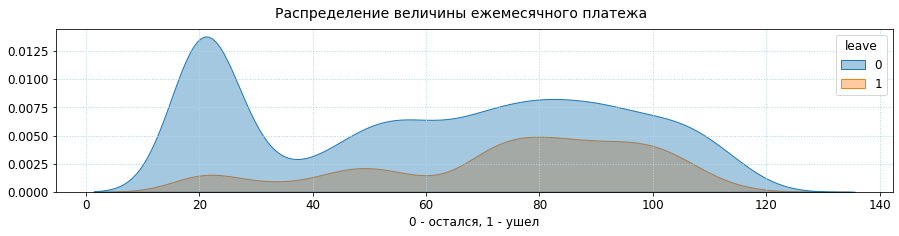

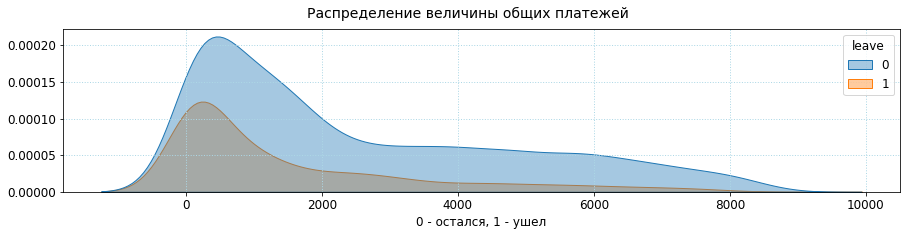

In [ ]:
kdeplot(all_df['MonthlyCharges'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Распределение величины ежемесячного платежа', 
        ylabel1='', hue1=all_df['leave'])

kdeplot(all_df['TotalCharges'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Распределение величины общих платежей', 
        ylabel1='', hue1=all_df['leave'])

plt.show()

Пик распределения величины ежемесячного платежа для ушедших клиетов выше, чем для оставшихся. Ушедшие клиенты платили больше. Возможно поэтому они ушли.

In [ ]:
all_df[['leave', 'MonthlyCharges', 'TotalCharges', 'delta']].groupby(by='leave').median()

,MonthlyCharges,TotalCharges,delta
leave,,,
0,64.425,1679.525,1157.0
1,79.650,703.550,304.0


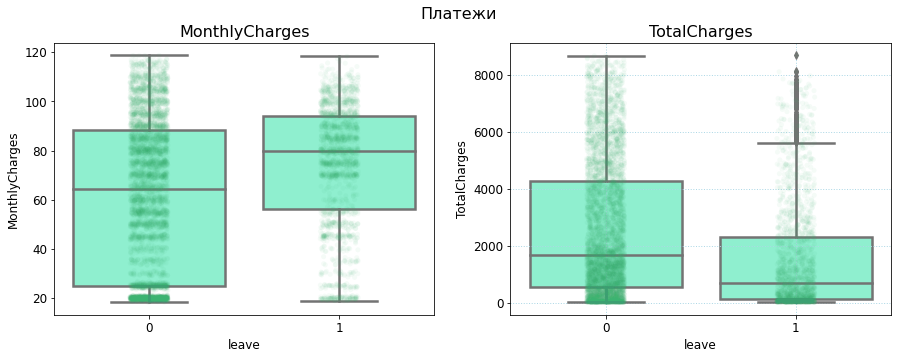

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
fig.suptitle('Платежи', fontsize=16)
       
sns.boxplot(x='leave', y='MonthlyCharges', data=all_df, color='aquamarine', linewidth=2.5, ax=axs[0])
sns.stripplot(x='leave', y='MonthlyCharges', data=all_df, marker="o", alpha=0.05, color="mediumseagreen", ax=axs[0])
        
axs[0].set_title('MonthlyCharges', fontsize=16)
plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')

sns.boxplot(x='leave', y='TotalCharges', data=all_df, color='aquamarine', linewidth=2.5, ax=axs[1])
sns.stripplot(x='leave', y='TotalCharges', data=all_df, marker="o", alpha=0.05, color="mediumseagreen", ax=axs[1])

axs[1].set_title('TotalCharges', fontsize=16)
plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')

Есть выбросы в общих платежах для ушедших клиентов. Они попадают в номарльные значения для оставшихся клиентов.
Разброс нормальных значений общих платежей для оставшихся клиентов от 0 до > 8000, для ушедших от 0 до 6000.

Медианный ежемесячный платеж у ушедих клиентов выше, в целом разброс значений ежемесячного платежа для обеих групп одинаковый.

Медианный ежемесячный платеж у ушедших клиентов выше на примерно 20%.

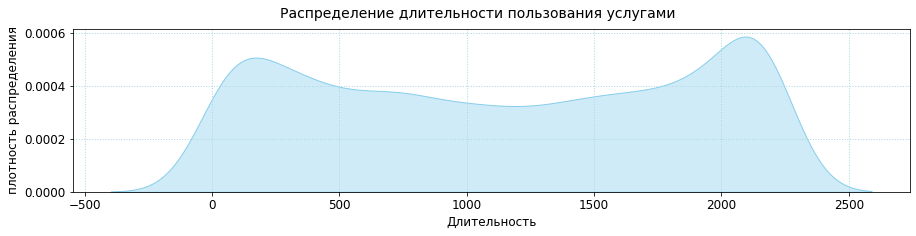

In [ ]:
kdeplot(data=all_df.loc[all_df['leave']==0]['duration'], 
            xlabel1='Длительность', 
            figsize_1=(15, 3), 
            suptitle1='Распределение длительности пользования услугами', 
            ylabel1='плотность распределения', 
            lg='количество дней')
plt.show()

На графике наблюдаются два пика - около 200 и около 2200. В целом, количество дней пользования услуг от 0 до 2500.

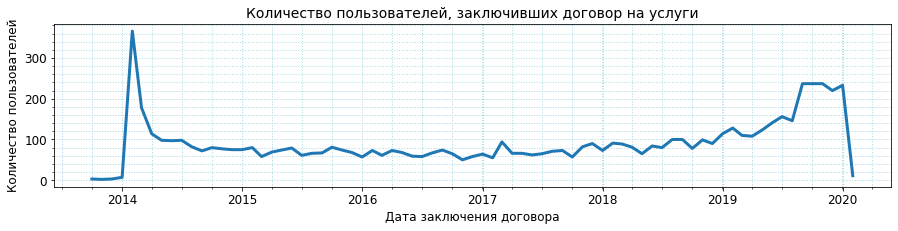

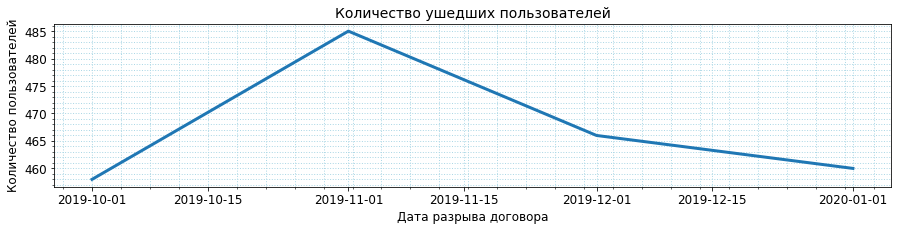

In [ ]:
oneplot(df=(all_df['BeginDate'].value_counts().sort_index(ascending=True)),
        title1='Количество пользователей, заключивших договор на услуги', 
        xl='Дата заключения договора', 
        yl='Количество пользователей')

oneplot(df=((all_df.loc[all_df['EndDate'] < '2020-02-01']['EndDate']).value_counts().sort_index(ascending=True)),
        title1='Количество ушедших пользователей', 
        xl='Дата разрыва договора', 
        yl='Количество пользователей')
plt.show()

Наибольшее количество клиентов заключили договор в 2014 году, более 300. В следующие года количество новых пользователей было примерно одинковым, и с 2019 года начало увеличиваться. С середины 2019 года произошел скачок, количество новых пользователей увеличилось до 200.

Уходить пользоавтели стали с конца 2019 года, или их уход не фиксировался.

Проверим выбросы в количественных признаках 'MonthlyCharges', 'TotalCharges'.

Проверим тип оплаты для оставшихся и ушедших клиентов.

In [ ]:
def share(column_, df=all_df):
    
    tabl = all_df[['leave',
                     'customerID',
                     column_]].groupby(by=['leave', 
                                           column_]).count().sort_values(by=['leave', 
                                                                             'customerID'], 
                                                                         ascending=False).reset_index()
    
    tabl['share_all'] = tabl['customerID'] / (tabl['customerID'].sum())
    
    tabl['share_leave'] = 0
    
    tabl.loc[tabl['leave']==0, 'share_leave'] = tabl['customerID'] / (df['leave'].value_counts()[0])
    
    tabl.loc[tabl['leave']==1, 'share_leave'] = tabl['customerID'] / (df['leave'].value_counts()[1])
    
    tabl[['share_leave', 'share_all']] = np.round((tabl[['share_leave', 'share_all']]), 2)
    
    return tabl

In [ ]:
Type_= share(column_='Type')
Type_

,leave,Type,customerID,share_all,share_leave
0,1,month-to-month,1655,0.23,0.89
1,1,one year,166,0.02,0.09
2,1,two year,48,0.01,0.03
3,0,month-to-month,2220,0.32,0.43
4,0,two year,1647,0.23,0.32
5,0,one year,1307,0.19,0.25


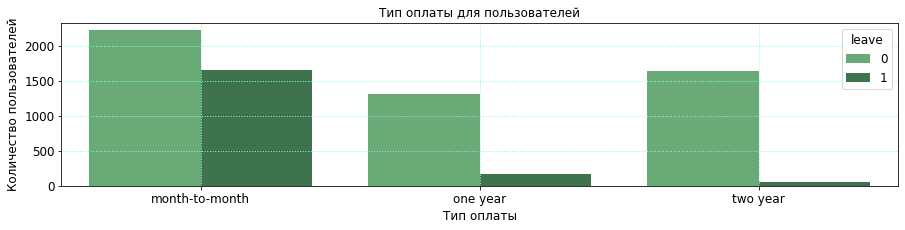

In [ ]:
barplot_sns(Type_, X=Type_['Type'], Y=Type_['customerID'], 
            title1='Тип оплаты для пользователей', xlabel1='Тип оплаты', 
            ylabel1='Количество пользователей', 
            figsize_1=(15, 3), h=Type_['leave'])
plt.show()

55% всех пользователей используют оплату month-to-month.
тип оплаты month-to-month используют в основном все ушедшие клиенты - их доля от общеего числа пользоватлеей составляет 23% и 88% от всех ушедших.
среди ушедших клиентов только 12% использовали тип оплаты one year или two year.

In [ ]:
payment_method = share(column_='PaymentMethod')
payment_method

,leave,PaymentMethod,customerID,share_all,share_leave
0,1,electronic check,1071,0.15,0.57
1,1,mailed check,308,0.04,0.16
2,1,bank transfer (automatic),258,0.04,0.14
3,1,credit card (automatic),232,0.03,0.12
4,0,mailed check,1304,0.19,0.25
5,0,electronic check,1294,0.18,0.25
6,0,credit card (automatic),1290,0.18,0.25
7,0,bank transfer (automatic),1286,0.18,0.25


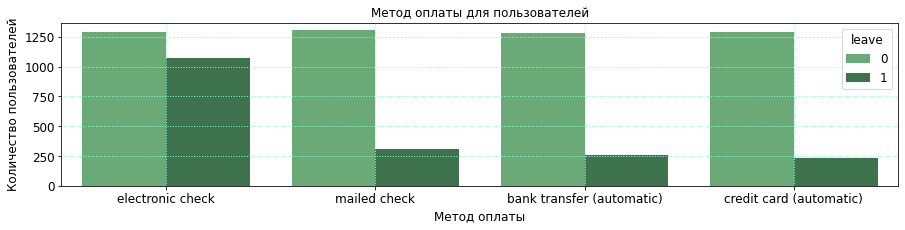

In [ ]:
barplot_sns(payment_method, X=payment_method['PaymentMethod'], Y=payment_method['customerID'], 
            title1='Метод оплаты для пользователей', xlabel1='Метод оплаты', 
            ylabel1='Количество пользователей', 
            figsize_1=(15, 3), h=payment_method['leave'])
plt.show()

Оставшиеся пользователи в равной степени используют все 4 метода оплаты, тогда как среди ушедших пользователей в основном использовался electronic check.

In [ ]:
int_type = share(column_='InternetService')
int_type

,leave,InternetService,customerID,share_all,share_leave
0,1,fiber optic,1297,0.18,0.69
1,1,dsl,459,0.07,0.25
2,1,no,113,0.02,0.06
3,0,dsl,1962,0.28,0.38
4,0,fiber optic,1799,0.26,0.35
5,0,no,1413,0.20,0.27


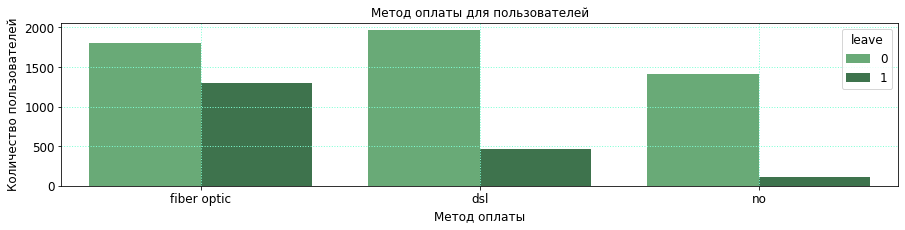

In [ ]:
barplot_sns(int_type, X=int_type['InternetService'], Y=int_type['customerID'], 
            title1='Метод оплаты для пользователей', xlabel1='Метод оплаты', 
            ylabel1='Количество пользователей', 
            figsize_1=(15, 3), h=int_type['leave'])
plt.show()

In [ ]:
int_type = share(column_='OnlineSecurity')
int_type

,leave,OnlineSecurity,customerID,share_all,share_leave
0,1,no,1574,0.22,0.84
1,1,yes,295,0.04,0.16
2,0,no,3450,0.49,0.67
3,0,yes,1724,0.24,0.33


In [ ]:
for i in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
          'TechSupport','StreamingTV', 'StreamingMovies']:
    display(share(column_=i))

,leave,OnlineSecurity,customerID,share_all,share_leave
0,1,no,1574,0.22,0.84
1,1,yes,295,0.04,0.16
2,0,no,3450,0.49,0.67
3,0,yes,1724,0.24,0.33


,leave,OnlineBackup,customerID,share_all,share_leave
0,1,no,1346,0.19,0.72
1,1,yes,523,0.07,0.28
2,0,no,3268,0.46,0.63
3,0,yes,1906,0.27,0.37


,leave,DeviceProtection,customerID,share_all,share_leave
0,1,no,1324,0.19,0.71
1,1,yes,545,0.08,0.29
2,0,no,3297,0.47,0.64
3,0,yes,1877,0.27,0.36


,leave,TechSupport,customerID,share_all,share_leave
0,1,no,1559,0.22,0.83
1,1,yes,310,0.04,0.17
2,0,no,3440,0.49,0.66
3,0,yes,1734,0.25,0.34


,leave,StreamingTV,customerID,share_all,share_leave
0,1,no,1055,0.15,0.56
1,1,yes,814,0.12,0.44
2,0,no,3281,0.47,0.63
3,0,yes,1893,0.27,0.37


,leave,StreamingMovies,customerID,share_all,share_leave
0,1,no,1051,0.15,0.56
1,1,yes,818,0.12,0.44
2,0,no,3260,0.46,0.63
3,0,yes,1914,0.27,0.37


In [ ]:
for i in ['gender', 'SeniorCitizen', 'Partner','Dependents']:
    display(share(column_=i))

,leave,gender,customerID,share_all,share_leave
0,1,female,939,0.13,0.50
1,1,male,930,0.13,0.50
2,0,male,2625,0.37,0.51
3,0,female,2549,0.36,0.49


,leave,SeniorCitizen,customerID,share_all,share_leave
0,1,0,1393,0.20,0.75
1,1,1,476,0.07,0.25
2,0,0,4508,0.64,0.87
3,0,1,666,0.09,0.13


,leave,Partner,customerID,share_all,share_leave
0,1,no,1200,0.17,0.64
1,1,yes,669,0.09,0.36
2,0,yes,2733,0.39,0.53
3,0,no,2441,0.35,0.47


,leave,Dependents,customerID,share_all,share_leave
0,1,no,1543,0.22,0.83
1,1,yes,326,0.05,0.17
2,0,no,3390,0.48,0.66
3,0,yes,1784,0.25,0.34


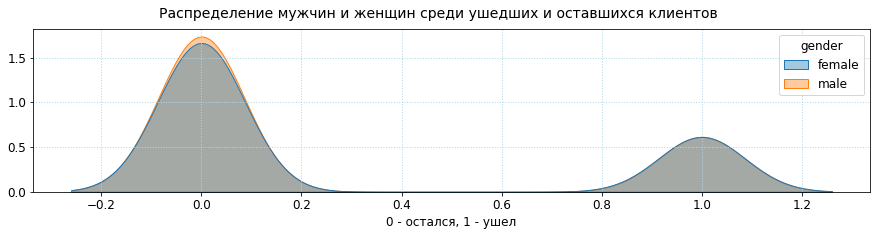

In [ ]:
kdeplot(all_df['leave'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Распределение мужчин и женщин среди ушедших и оставшихся клиентов', 
        ylabel1='', hue1=all_df['gender'])
plt.show()

Распределение одинаковое и для женщин и для мужчин. Пол не влияет на факт ухода клиента.

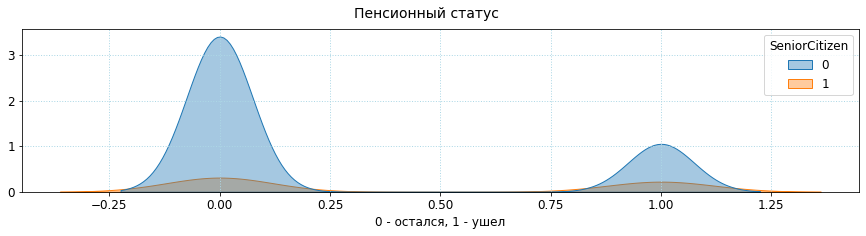

In [ ]:
kdeplot(all_df['leave'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Пенсионный статус', 
        ylabel1='', hue1=all_df['SeniorCitizen'])
plt.show()

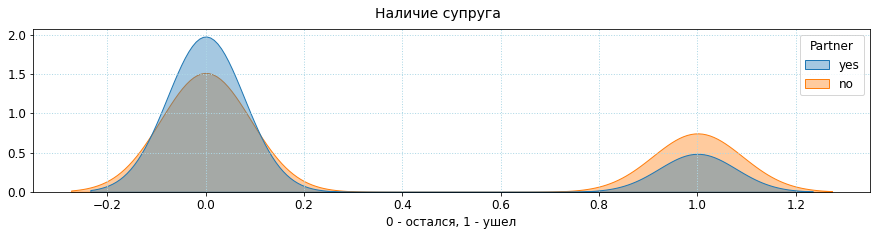

In [ ]:
kdeplot(all_df['leave'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Наличие супруга', 
        ylabel1='', hue1=all_df['Partner'])
plt.show()

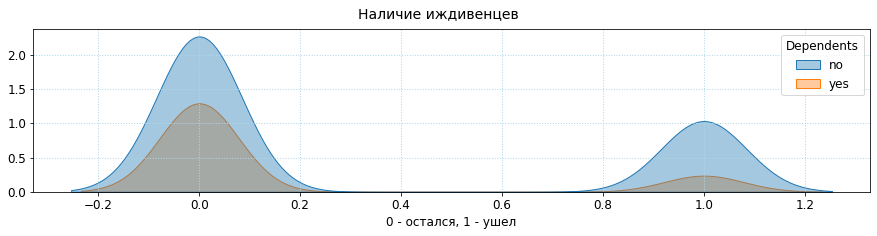

In [ ]:
kdeplot(all_df['leave'], xlabel1='0 - остался, 1 - ушел',figsize_1=(15, 3), 
        suptitle1='Наличие иждивенцев', 
        ylabel1='', hue1=all_df['Dependents'])
plt.show()

В целом, ушедших клиентов без супруга больше, чем с супругом. У 64% ушедших пользователей спруга нет.
В остальном, уход клиента с персональными данными не связан.

In [ ]:
tel = share(column_='MultipleLines')
tel

,leave,MultipleLines,customerID,share_all,share_leave
0,1,yes,850,0.12,0.45
1,1,no,849,0.12,0.45
2,1,empty,170,0.02,0.09
3,0,no,2541,0.36,0.49
4,0,yes,2121,0.30,0.41
5,0,empty,512,0.07,0.10


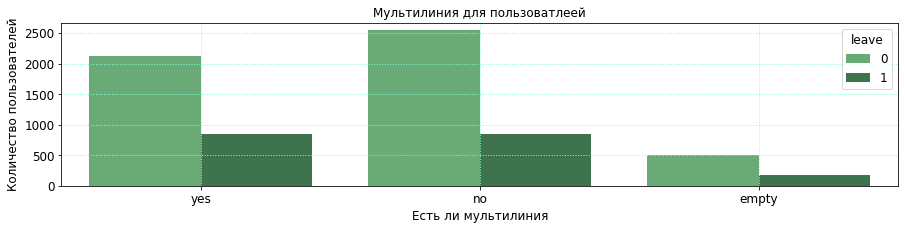

In [ ]:
barplot_sns(tel, X=tel['MultipleLines'], Y=tel['customerID'], 
            title1='Мультилиния для пользоватлеей', xlabel1='Есть ли мультилиния', 
            ylabel1='Количество пользователей', 
            figsize_1=(15, 3), h=tel['leave'])
plt.show()

В основном, ушедшие пользователи поделились на два типа - 45% пользовались 1 линией телефона, другие 45% более 1 линией.
Пользователей без телефонной линией по 10% в каждой группе.

Проверим корреляцию признаков.

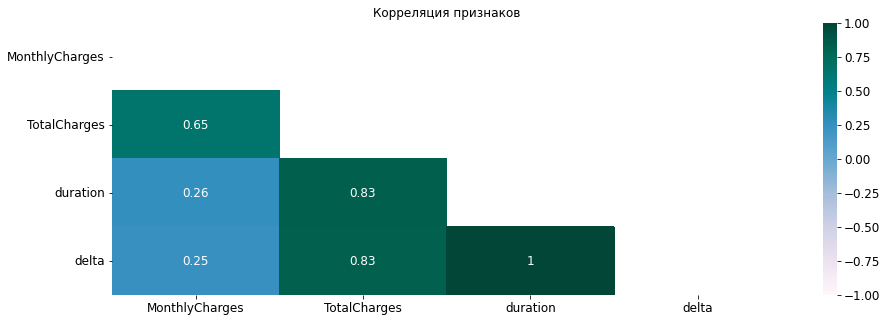

In [ ]:
heatmap_b(all_df[['MonthlyCharges', 'TotalCharges', 'duration', 'delta']], title_1='Корреляция признаков', size=(15, 5))
plt.show()

Сумма общих платежей зависит от ежемесячного платежа и длительности использования услуг на текущую даты (дату выгрузки).

Проверим гипотезу о том, что *ежемесячный платеж ушедших и оставшихся клиентов различается.*

- H0 - нулевая гипотеза:
средний ежемесячный платеж для ушедших и оставшихся клиентов не различается.

- H1 - альтернативная гипотеза:
средний ежемесячный платеж у ушедших и оставшихся клиентов разный.

In [ ]:
monthly_pay_leave = all_df.query('leave == 1')['MonthlyCharges']
monthly_pay_stay = all_df.query('leave == 0')['MonthlyCharges']

In [ ]:
alpha = .05 # критический уровень статистичесой значимости

results = st.ttest_ind(monthly_pay_leave, monthly_pay_stay) 

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  2.706645606888261e-60
Отвергаем нулевую гипотезу


pvalue < 0.05, следовательно нулевую гипотезу можно отклонить и принять H1:
средние величины ежемесячного платежа у ушедших и оставшихся клиентов разные.

# Вывод по исследовательскому анализу данных

- Столбец TotalCharges таблицы contract приведен к типу float.
- Столбец BeginDate, EndDate приведен к типу datetime.
- Категория no в стобце EndDate заменена на дату выгрузки данных - 2020-02-01.
- Таблицы соединены в единый датасет по столбцу customerID. Размер полученного датасета - 7043 строки и 20 столбцов. Все исходные данные сохранены.
- Добавлены столбцы:
- Целевой признак - ушел клиент или нет - 'leave'.
- Столбец с количеством дней до разрыва договора на услуги 'delta'.
- Столбец с количеством дней от заключения контракта до выгрузки данных 'duration'
- До 50% пользователей уходят до года пользования услугами - около 304 дней.
- Медианный ежемесячный платеж у ушедших клиентов выше, чем у оставшихся около 20%. При этом, общее количество платежей для ушедших клиентов ниже.
- Гипотеза о том, что ежемесячные платежи у ушедших клиентов и оставшихся разные подтвердилась.
- На дату выгрузки данных, в основном, все пользователи использовали услуги компании от 100 до 2200 дней.
- Уходить пользователи стали с конца 2019 года, или их уход не фиксировался.
- 55% всех пользователей используют оплату month-to-month.
- Тип оплаты month-to-month используют в основном все ушедшие клиенты - их доля составляет 23% от всех пользователей и 88% от всех ушедших пользователей.
- Среди ушедших клиентов только 12% использовали тип оплаты one year или two year.
- Оставшиеся пользователи в равной степени используют все 4 метода оплаты, тогда как среди ушедших пользователей в основном использовался electronic check - 57%.
- Основная часть ушедших пользователей использовала интренет по оптоволокну - fiber optic - их доля 18% от всех пользователей и 70% от ушедших.
- DSL используют 35% пользователей.
- 70-80 % ушедшиих клиентов не пользовались дополнительными услугами, за исключением StreamingTV, StreamingMovies. Около 60% ушедших пользоватлеей использовали StreamingTV, StreamingMovies.
- У 64% ушедших пользователей спруга нет, в то время как у оставшихся клиентов нет супруга только у 47%.
- Ушедшие пользователи поделились на два типа - 45% пользовались 1 линией телефона, другие 45% более 1 линией.
- Целевой признак 'leave' зависит от количества дней от регитсрации до ухода клиента - это утечка признака.


# Подготовим признаки

- закодируем категориальные признаки
- разобьем выборку в отношении 75%(train) и 25%(test), выделим целевой признак и удалим ненужные столбцы
- проверим баланс классов и масштаб признаков

# Разобъём выборки на train и test

In [ ]:
all_df.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines', 'leave', 'duration', 'delta'],
      dtype='object')

In [ ]:
target = all_df['leave']

features = all_df.drop(['leave', 'customerID', 'BeginDate', 'EndDate', 'delta', 
                          'MultipleLines', 'PaperlessBilling', 'DeviceProtection',
                         'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                          'Dependents', 'MultipleLines', 'gender'], axis=1)

- Столбец 'customerID' несет в себе персонализированную информацию, поэтому его стоит удалить перед обучением
- Для обучения не понадобятся даты заключения договора и окончания договора. 
- Добавленный столбец 'delta' так же нужно удалить, так как он является утечкой целевого признака
- Столбец duration оставляем, так как у нас есть информация о дате заключения договора и продолжительность времени (дни) сколько клиент с компанией на дату сбора датасета/ текущую дату.
- Так же, удалим несколько столбцов с информацией об услугах, так как они взаимосвязаны с ежемесячным платежом и суммой общих расходов.
- Целевой признак выделен в отдельный столбец - leave с классами 0 - клиент не ушел, 1 - клиент ушел.

In [ ]:
features.head()

,Type,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Partner,duration
0,month-to-month,electronic check,29.85,29.85,dsl,no,no,no,0,yes,31
1,one year,mailed check,56.95,1889.50,dsl,no,no,no,0,no,1036
2,month-to-month,mailed check,53.85,108.15,dsl,no,no,no,0,no,123
3,one year,bank transfer (automatic),42.30,1840.75,dsl,yes,no,no,0,no,1371
4,month-to-month,electronic check,70.70,151.65,fiber optic,no,no,no,0,no,153


In [ ]:
print('Размер признаков:', target.shape)
print('Размер целевого признака:', features.shape)

Размер признаков: (7043,)
Размер целевого признака: (7043, 11)


Разделим выборки и по условию значение random_state=160123

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.25, random_state=160123)

Проверим размеры получившихся выборок:

In [ ]:
print('Размер тренировочной выборки признаков:', X_train.shape, 
          'целевого признака:', y_train.shape, sep='\n')
print('Размер тестовой выборки признаков:', X_test.shape, 
          'целевого признака:', y_test.shape, sep='\n')

Размер тренировочной выборки признаков:
(5282, 11)
целевого признака:
(5282,)
Размер тестовой выборки признаков:
(1761, 11)
целевого признака:
(1761,)


Проверим баланс классов:

In [ ]:
def class_frequency(data):    
    class_frequency_data = data.value_counts(normalize=True).to_frame()
    return class_frequency_data

In [ ]:
pd.concat([y_train.value_counts(), y_test.value_counts()], axis=1)

,leave,leave
0,3891,1283
1,1391,478


Посмотрим распределение на графике:

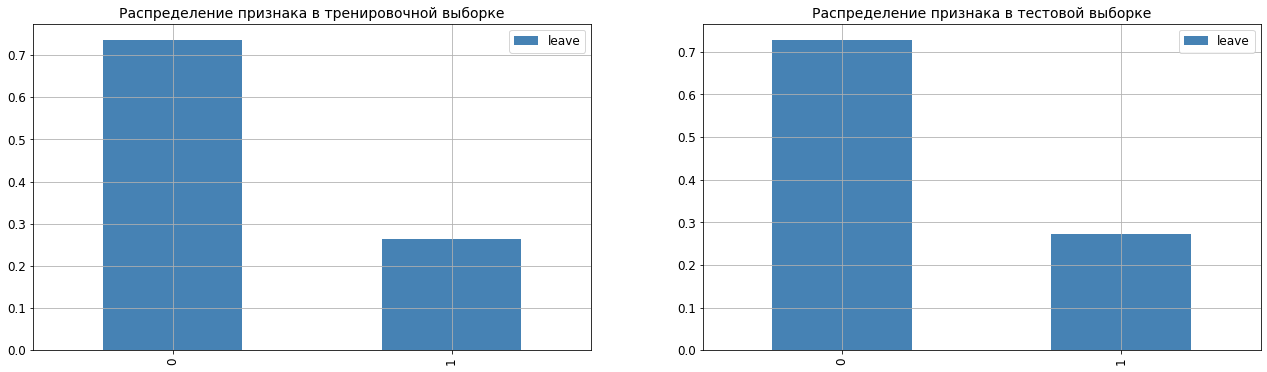

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(22,6))

class_frequency(y_train).plot(kind='bar', 
                                   ax=axes[0], 
                                   color='steelblue').set_title('Распределение признака в тренировочной выборке', 
                                                          fontdict={'fontsize': 14})
axes[0].grid()
class_frequency(y_test).plot(kind='bar', 
                                   ax=axes[1], 
                                   color='steelblue').set_title('Распределение признака в тестовой выборке', 
                                                                     fontdict={'fontsize': 14})
axes[1].grid()
plt.show()

Класса 1 в три раза меньше, чем 0. Данных для обучения достаточно.

Проверим масштаб признаков:

In [ ]:
def kde_one(df, title_1, ncols_1=1, figsize_1=(20, 5), step=80, fontsize_1=14, loc1='upper right'):

    fig, (ax1) = plt.subplots(ncols=ncols_1, figsize=figsize_1)
    
    ax1.set_title(title_1, fontsize=16)
    
    cmap = plt.get_cmap('GnBu')
    
    b_colors = cmap(np.array([i for i in range(50, 500, step)]))

    for i in range(len(df.columns)):
        
        sns.kdeplot(df.iloc[:, i], ax = ax1, shade=True, legend=True, color=b_colors[i], label=df.columns[i])
        
    plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')
    plt.legend(fontsize=fontsize_1, loc=loc1)
    plt.show() 

In [ ]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,5282.0,65.016329,30.087404,18.40,36.0000,70.55,89.9000,118.65
TotalCharges,5282.0,2300.810081,2270.639007,18.85,413.0625,1418.65,3820.6875,8547.15
SeniorCitizen,5282.0,0.161113,0.367670,0.00,0.0000,0.00,0.0000,1.00
duration,5282.0,1012.441121,738.073758,0.00,306.0000,914.00,1706.0000,2314.00


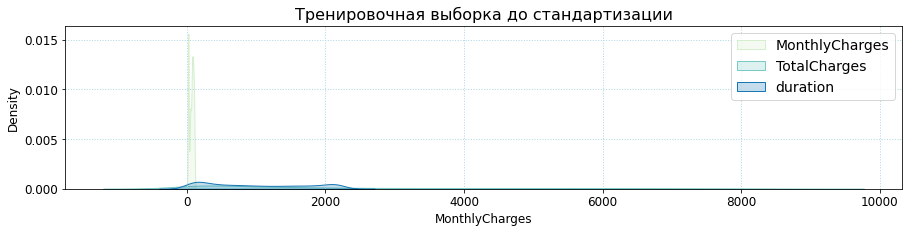

In [ ]:
kde_one(X_train[['MonthlyCharges', 'TotalCharges', 'duration']], 
        title_1='Тренировочная выборка до стандартизации', figsize_1=(15, 3))

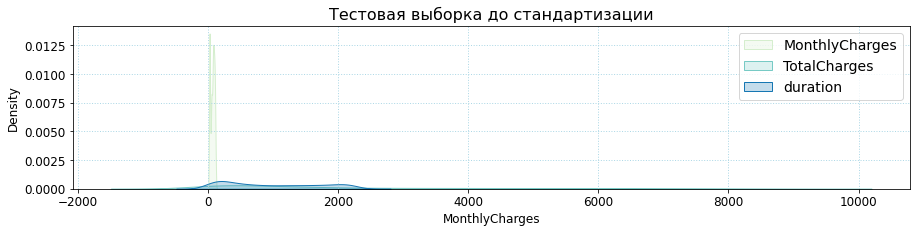

In [ ]:
kde_one(X_test[['MonthlyCharges', 'TotalCharges', 'duration']], 
        title_1='Тестовая выборка до стандартизации', figsize_1=(15, 3))

- Столбцы ['MonthlyCharges', 'TotalCharges', 'duration'] имеют различные величины стандартного отклонения, среднего, минимального и максимального значений. 
- Добавим стандартизацию в пайплайн для обучения модели.

# Обучение моделей

Функция heatmap_confusion_matrix(best_predictions, name='Матрица ошибок модели', target=y_test) принимает на вход:

- best_predictions - предсказания модели
- name - название графика
- target=y_test - истиные значения классов.

Возвращает матрицу в виде тепловой карты.

Создадим функцию для построения тепловой карты по матрице ошибок модели

In [ ]:
def heatmap_confusion_matrix(best_predictions, name='Матрица ошибок модели', target=y_test):

    heatmap_1 = sns.heatmap((confusion_matrix(target, best_predictions)), 
                            cmap="PuBuGn", 
                            annot=True, fmt='d')
    
    heatmap_1.set_title(name, fontdict={'fontsize':14})
    heatmap_1.set_xlabel('Предсказания', fontsize=14)
    heatmap_1.set_ylabel('Истинный класс', fontsize=14)
    
    return heatmap_1

Функция plot_ROC(fpr, tpr, name='ROC-кривая') принимает на вход:

- fpr - вероятность ложноположительного предсказания
- tpr - вероятность истиннополоительного предсказания
- name - название графика.

Возвращает ROC кривую.

In [ ]:
def plot_ROC(fpr, tpr, name='ROC-кривая'):
    
    plot_ROC = plt.plot(fpr, tpr, color='mediumblue')
    plot_ROC = plt.plot([0, 1], [0, 1], linestyle='--', color='r')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(name)
   
    return plot_ROC

Функция plot_feature_importance(impotance, fi_yerr, fsize=(12, 5), name='имя модели') принимает на вход:

- impotance - значения важности признаков
- fi_yerr - вертикальные полосы погрешностей
- fsize - размер гарфика
- name - имя модели

Возвращает график важности признаков.

In [ ]:
def plot_feature_importance(impotance, fi_yerr, fsize=(12, 5), name='имя модели'):
    
    fig, ax = plt.subplots(figsize=fsize)
    
    impotance.plot.bar(yerr=fi_yerr, ax=ax, color='steelblue', grid=True)
    ax.set_title("Важность признаков для " + name)
    ax.set_ylabel('Важность признака')
    fig.tight_layout()

Функция rndm_test (model, params, features=X_train, target=y_train, feature_test=X_test, target_test=y_test, name_est='model'):

Принимает на вход:

- model - модель
- params - параметры модели для перебора гиперпараметров
- features, target, feature_test, target_test - обучающие и тестируемые наборы
- name_est - название модели

Функция выполняет:

- строит пайплайн с двумя шагами - стандартизацией и моделью
- с помощью RandomizedSearchCV подбирает лучшие гиперпараметры, возвращает модель, лучшую оценку ROC-AUC.
- Тестирует модель с подобранными гиперпараметрами на тестовой выборке.
- Предстказывает вероятности на тестовой выборке
- Рассчитывает AUC-ROC, F1, accuracy на тестовой выборке
- Печатает на экране результаты
- Выводит на экран тепловую карту матрицы путанницы и ROC-кривую модели
- Все результаты метрик модели сохраняются в датасет results

Возвращает:
- модель, результаты в виде таблицы, предсказания на тестовой выборке.

In [ ]:
def rndm_test(model, params, features=X_train, 
              target=y_train, feature_test=X_test, 
              target_test=y_test, name_est='model'):
    
    # пайплайн + шаги (здесь кодирую признаки)
    num_cols = features.select_dtypes(['float', 'int64']).columns.to_list()
    cat_cols = features.select_dtypes(['category', 'object']).columns.to_list()

    transformer = ColumnTransformer(transformers=[
                    ('scaler', StandardScaler(), num_cols),
                    ('ohe', OneHotEncoder(drop='first'), cat_cols)
                    ])
    
    pipe = Pipeline(steps=[
        ('transformer', transformer),
        ('model', model)
    ])

    # поиск параметров + лучшая модель и результат roc_auc
    RSCV = RandomizedSearchCV(estimator=pipe, param_distributions=params, 
                              cv=5, n_jobs=-1, scoring='roc_auc', random_state=160123)

    RSCV.fit(features, target)

    best_estimator = RSCV.best_estimator_
    best_score = RSCV.best_score_

     # вероятности
    probabilities_valid = cross_val_predict(best_estimator, features, target, cv=5, method='predict_proba')
    probabilities_one_valid = probabilities_valid[:, 1]

     # расчет метрик на трейне
    auc_roc_train = roc_auc_score(target, probabilities_one_valid)
    fpr_t, tpr_t, thresholds_t = roc_curve(target, probabilities_one_valid)
   
    # все результаты, в том числе модель 
    print('Модель с лучшими гиперпараметрами:')
    print(best_estimator)
    print('ROC-AUC на тренировочной выборке: {:.5f}'.format(best_score))
    # ROC_кривая
    plt.figure()
    plot_roc = plot_ROC(fpr=fpr_t, tpr=tpr_t, name=('ROC-кривая '+name_est))
    plt.show()   
    return best_estimator

# LogisticRegression 

In [ ]:
log_reg_params = {'model__C': [1, 2, 3, 5], 
                  'model__class_weight': [None, 'balanced'],
                  'model__fit_intercept': [True, False],
                  'model__l1_ratio': [None],
                  'model__max_iter': [100, 200, 70],
                  'model__n_jobs': [-1],
                  'model__penalty': ['l2'],
                  'model__random_state': [160123],
                  'model__solver': ['lbfgs', 'newton-cg', 'lbfgs', 'sag', 'saga'],
                  'model__tol': [0.0001, 0.001],}

In [ ]:
lg_model = LogisticRegression()

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'SeniorCitizen',
                                                   'duration']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Type', 'PaymentMethod',
                                                   'InternetService',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Partner'])])),
                ('model',
                 LogisticRegression(C=1, max_iter=200, n_job

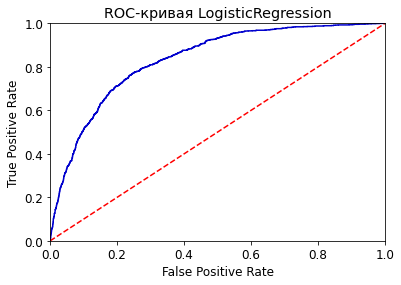

CPU times: user 1.53 s, sys: 316 ms, total: 1.84 s
Wall time: 9.69 s


In [ ]:
%%time 
lg_model = rndm_test(lg_model, log_reg_params, name_est='LogisticRegression')

# RandomForestClassifier

In [ ]:
forest = RandomForestClassifier()

In [ ]:
forest_param = {'model__ccp_alpha': [0, 0.5, 1, 2],
                'model__class_weight': [None, 'balanced', 'balanced_subsample'],
                'model__criterion': ['gini', 'entropy'],
                'model__max_depth': [2, 5, 10],
                'model__max_features': ['auto', 6, 10],
                'model__min_samples_leaf': [1, 3, 4],
                'model__min_samples_split': [2, 4, 6],
                'model__n_estimators': [300, 150, 400, 500], 
                'model__n_jobs': [-1], 
                'model__random_state': [160123]}

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'SeniorCitizen',
                                                   'duration']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Type', 'PaymentMethod',
                                                   'InternetService',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Partner'])])),
                ('model',
                 RandomForestClassifier(ccp_alpha=0, max_dep

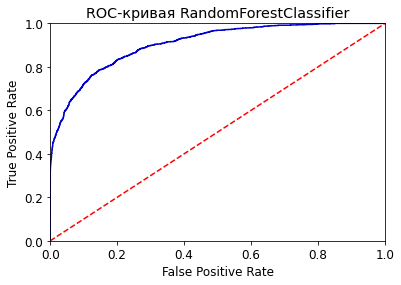

CPU times: user 8.87 s, sys: 411 ms, total: 9.28 s
Wall time: 1min 22s


In [ ]:
%%time 
forest_model = rndm_test(forest, forest_param, name_est='RandomForestClassifier')

# LGBMClassifier

In [ ]:
lgbm_class = lgb.LGBMClassifier()

In [ ]:
lgbm_class_param = {'model__boosting_type': ['gbdt', 'dart', 'goss'], 
                    'model__class_weight': [None, 'balanced'], 
                    'model__importance_type': ['split', 'gain'], 
                    'model__learning_rate': [0.1, 0.05, 0.3, 0.01, 0.6], 
                    'model__max_depth': [-1, 3, 5, 6], 
                    'model__n_estimators': [50, 100, 150, 500, 1000], 
                    'model__n_jobs': [-1], 
                    'model__random_state': [160123], 
                    'model__subsample_for_bin': [200000, 50000, 100000]}

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['MonthlyCharges',
                                                   'TotalCharges',
                                                   'SeniorCitizen',
                                                   'duration']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['Type', 'PaymentMethod',
                                                   'InternetService',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Partner'])])),
                ('model',
                 LGBMClassifier(boosting_type='goss', class_

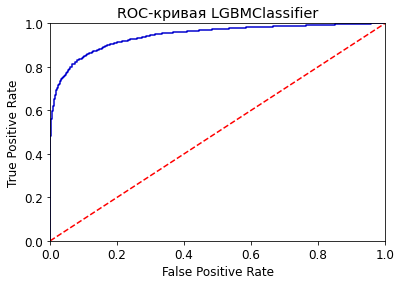

In [ ]:
# %%time 
lgbm_class_model = rndm_test(lgbm_class, lgbm_class_param, name_est='LGBMClassifier')

# CatBoostClassifier

In [ ]:
cat_m = CatBoostClassifier()

In [ ]:
cat_param = {'model__random_state': [160123], 'model__iterations': [500], 
             'model__depth': [3, 5, 7, 10], 'model__learning_rate': [.1, .01, .5], 
             'model__l2_leaf_reg': [1, 3, 5, 10], 'model__loss_function': ['Logloss', 'CrossEntropy'],
            'model__eval_metric': ['AUC'],}

0:	total: 2.65ms	remaining: 1.32s
1:	total: 4.46ms	remaining: 1.11s
2:	total: 6.41ms	remaining: 1.06s
3:	total: 9.41ms	remaining: 1.17s
4:	total: 11.1ms	remaining: 1.09s
5:	total: 12.9ms	remaining: 1.06s
6:	total: 14.4ms	remaining: 1.02s
7:	total: 16.5ms	remaining: 1.01s
8:	total: 18.5ms	remaining: 1.01s
9:	total: 20.4ms	remaining: 1s
10:	total: 22.5ms	remaining: 999ms
11:	total: 24.3ms	remaining: 990ms
12:	total: 26.5ms	remaining: 993ms
13:	total: 28.4ms	remaining: 987ms
14:	total: 30.4ms	remaining: 982ms
15:	total: 32.1ms	remaining: 972ms
16:	total: 34.1ms	remaining: 970ms
17:	total: 36.1ms	remaining: 967ms
18:	total: 38ms	remaining: 963ms
19:	total: 39.9ms	remaining: 959ms
20:	total: 41.9ms	remaining: 955ms
21:	total: 43.7ms	remaining: 949ms
22:	total: 45.5ms	remaining: 944ms
23:	total: 50.5ms	remaining: 1s
24:	total: 52.2ms	remaining: 992ms
25:	total: 53.8ms	remaining: 982ms
26:	total: 55.8ms	remaining: 978ms
27:	total: 57.7ms	remaining: 972ms
28:	total: 59.6ms	remaining: 967ms
29:

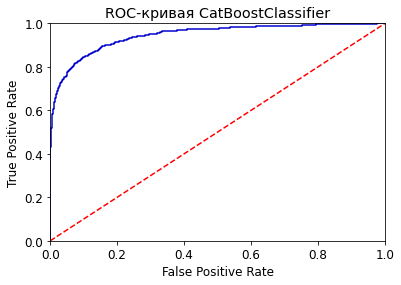

CPU times: user 11 s, sys: 1.44 s, total: 12.4 s
Wall time: 2min 59s


In [ ]:
%%time 
model_cat = rndm_test(cat_m, cat_param, name_est='CatBoostClassifier')

In [ ]:
print(model_cat[1].get_params())

{'iterations': 500, 'learning_rate': 0.5, 'depth': 3, 'l2_leaf_reg': 1, 'loss_function': 'CrossEntropy', 'eval_metric': 'AUC', 'random_state': 160123}


Анализ моделей

Сравним результат работы моделей с Dummy моделью, а так же, выведем на экран результаты метрик всех моделей.

In [ ]:
dummy_class = DummyClassifier(strategy='most_frequent')
dummy_class.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [ ]:
pred_dummy= dummy_class.predict(X_test)

probabilities_valid = dummy_class.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

dummy_auc_roc = roc_auc_score(y_test, probabilities_one_valid)

dummy_f1 = f1_score(y_test, pred_dummy, zero_division=0)
    
dummy_accuracy = dummy_class.score(X_test, y_test)

results_dummy = pd.DataFrame({'DummyClassifier': [dummy_auc_roc, 
                                         dummy_f1, 
                                         dummy_accuracy]}, index=['AUC-ROC', 
                                                                 'F1', 
                                                                 'Accuracy'])
results_dummy

,DummyClassifier
AUC-ROC,0.500000
F1,0.000000
Accuracy,0.728563


Вывод: Лучшей моделью на тренировочной выборке показала себя модель CatBoost с такими параметрами ('iterations': 500, 'learning_rate': 0.5, 'depth': 3, 'l2_leaf_reg': 1, 'loss_function': 'CrossEntropy', 'eval_metric': 'AUC', 'random_state': 160123) Возьмём её для проверки на тесте

In [ ]:
result = pd.DataFrame({'Catboost': [0.94324]}, index=['AUC-ROC'])
result

,Catboost
AUC-ROC,0.94324


# Проверка лучшей модели на тесте

Класс модели:  CatBoostClassifier
roc-auc:  0.948343644113398
accuracy 0.9080068143100511


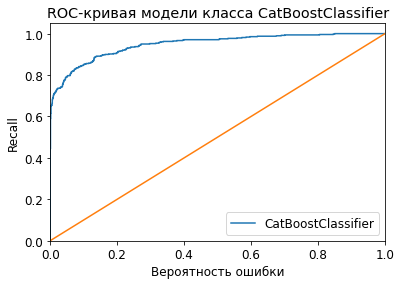

In [ ]:
predictions_test = model_cat.predict(X_test)
probabilities_test = model_cat.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probabilities_test)
    
roc_auc = roc_auc_score(y_test, probabilities_test)
accuracy = accuracy_score(y_test, predictions_test)
   
print('Класс модели: ', type(cat_m).__name__)
print('roc-auc: ', roc_auc)
print('accuracy', accuracy)    
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test, pos_label=1)
plt.plot(fpr, tpr, label=type(cat_m).__name__)
plt.xlabel('Вероятность ошибки')
plt.ylabel('Recall')
plt.title('ROC-кривая модели класса ' + type(cat_m).__name__)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend();

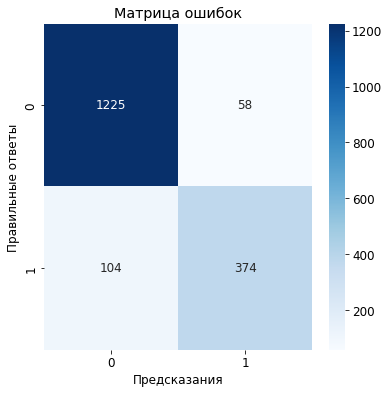

In [ ]:
cmatrix = confusion_matrix(y_test, predictions_test)
plt.figure(figsize=(6, 6))
sns.heatmap(cmatrix, 
            annot=True,  
            cmap='Blues', 
            fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
plt.show();

Анализ результатов

# Вывод

- Результаты работы всех моделей лучше, чем Дамми модели, за исключением RandomForestClassifier. 
- Accuracy на тестовой выборке RandomForestClassifier 0.7 ниже, чем Accuracy Dummy модели 0.73.
- AUC-ROC выше у всех моделей.
- Лучшую метрику показала модель CatBoostClassifier c AUC-ROC на тестовой выборке 0.948

# Отчёт по работе 

- Целью исследования было создать модель, которая на основании имеющихся даннных будет предсказывать уход клиента от компании. Целевой метрикой оценки точности предсказания модели считатется AUC-ROC
- Исходные данные состояли из 4 таблиц с информацией о датах заключения контракта, дате разрыва контракта, сумм затрат на ежемесячные платежи и общих сумм затрат клиента, персональной информации о клиентах, сведения об услугах интрернета, телефонии и доп. услугах.

- Исходные 4 таблицы были объединены в один датасет.
Изначально было обнаружено 11 пропусков в столбце 'TotalCharges' для пользователей, которые оформили договор на момет выгрузки данных. Так как не все клиенты пользовались услугами интернета/телефона, то после объединения появились пропущенные значения в количестве 1526 шт. для столбцов из таблицы internet и 682 пропуска для столбца телефонии.
Все они были обработаны на подходящие значения.

- Из датасета был выделен целевой признак - 'leave' - факт ухода клиента. Так же, был добавлен столбец с количеством дней от регистрации договора до текущей даты/даты выгрузки.

Для прогнозирования оттока клиентов использовался дополнительный параметр период действия договора.

- Целевая переменная определялась по столбцу 'leave'.
   
- Также были выделены самые важные признаки, которые больше всего влияют на отток клиентов:

- Период пользования услугами
- Месячные траты на услуги
- Тип договора
- Интернет сервис, используемый клиентом.
- Способ оплаты
- Безналичный рассчет.
    
    
- Значимых отличий от плана, и ключевых этапов не было
- Трудностей не возникало.

- До 50% пользователей уходят до года пользования услугами - около 304 дней.
Медианный ежемесячный платеж у ушедших клиентов выше, чем у оставшихся около 20%. При этом, общее количество платежей для ушедших клиентов ниже.
- Гипотеза о том, что ежемесячные платежи у ушедших клиентов и оставшихся разные подтвердилась: p-value < 0.05.
- На дату выгрузки данных, в основном, все пользователи использовали услуги компании от 100 до 2200 дней.
- Уходить пользователи стали с конца 2019 года, или их уход не фиксировался.
55% всех пользователей используют оплату month-to-month.
- Тип оплаты month-to-month используют в основном все ушедшие клиенты - их доля составляет 23% от всех пользователей и 88% от всех ушедших пользователей.
- Среди ушедших клиентов только 12% использовали тип оплаты one year или two year. Оставшиеся пользователи в равной степени используют все 4 метода оплаты, тогда как среди ушедших пользователей в основном использовался electronic check - 57%.
- Основная часть ушедших пользователей использовала интренет по оптоволокну - fiber optic - их доля 18% от всех пользователей и 70% от ушедших.
DSL используют 35% пользователей.
- 70-80 % ушедшиих клиентов не пользовались дополнительными услугами, за исключением StreamingTV, StreamingMovies. Около 60% ушедших пользоватлеей использовали StreamingTV, StreamingMovies.
- У 64% ушедших пользователей спруга нет, в то время как у оставшихся клиентов нет супруга только у 47%.
- Ушедшие пользователи поделились на два типа - 45% пользовались 1 линией телефона, другие 45% более 1 линией.

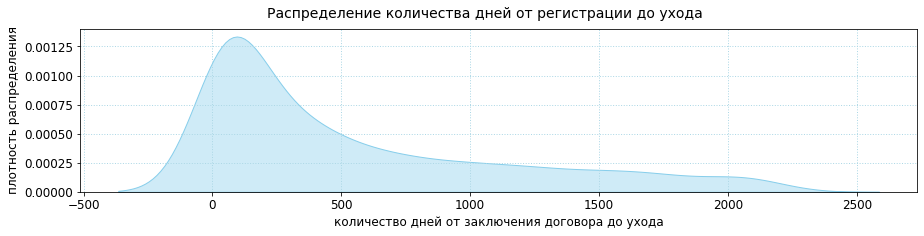

In [ ]:
kdeplot(data=all_df.loc[all_df['leave'] > 0]['delta'], 
        xlabel1='количество дней от заключения договора до ухода', 
        figsize_1=(15, 3), 
        suptitle1='Распределение количества дней от регистрации до ухода', 
        ylabel1='плотность распределения', 
        lg='количество дней')
plt.show()

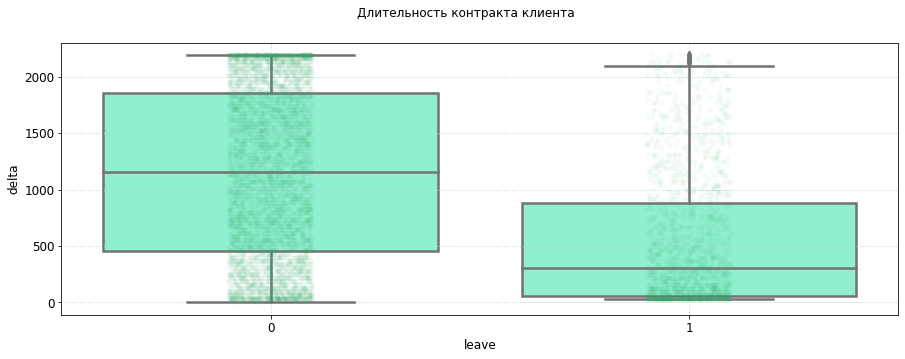

In [ ]:
fig, axs = plt.subplots(figsize=(15, 5))
    
fig.suptitle('Длительность контракта клиента', fontsize=12)
       
sns.boxplot(x='leave', y='delta', data=all_df, color='aquamarine', linewidth=2.5)
sns.stripplot(x='leave', y='delta', data=all_df, marker="o", alpha=0.05, color="mediumseagreen")
        
plt.grid(color = 'lightblue', linewidth = 1, linestyle=':')

- Для решения задачи классификации и предсказания факта ухода клиента были обучены 2 модели градиентного бустинга, одна линейная модель и модель случайного леса, а именно:

- LGBMClassifier
- CatBoostClassifier
- LogisticRegression
- RandomForestClassifier

- Выборка была разделена на тренировочную и тестовую части в отношении 75%:25%.

- Выбор модели и подбор гиперпараметров осуществлялся с помощью RandomizedSearchCV с кросс-валидацией. Была выполнена стандартизация с помощью пайплайна.

- В целом, модели градиентного бустинга дают примерно одинковый результат предсказания на тестовой выборке AUC-ROC от 0.94 и это лучший результат по сравнению с другими моделями:
- AUC-ROC для LogisticRegression - 0,82
- AUC-ROC для RandomForestClassifier - 0,83

- Лучшей оказалась CatBoost модель с параметрами:

In [ ]:
print(model_cat[1].get_params())

{'iterations': 500, 'learning_rate': 0.5, 'depth': 3, 'l2_leaf_reg': 1, 'loss_function': 'CrossEntropy', 'eval_metric': 'AUC', 'random_state': 160123}


Класс модели:  CatBoostClassifier
roc-auc:  0.948343644113398
accuracy 0.9080068143100511


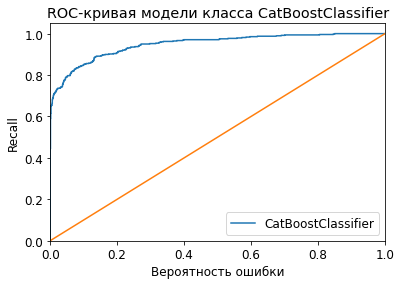

In [ ]:
predictions_test = model_cat.predict(X_test)
probabilities_test = model_cat.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, probabilities_test)
    
roc_auc = roc_auc_score(y_test, probabilities_test)
accuracy = accuracy_score(y_test, predictions_test)
   
print('Класс модели: ', type(cat_m).__name__)
print('roc-auc: ', roc_auc)
print('accuracy', accuracy)    
fpr, tpr, thresholds = roc_curve(y_test, probabilities_test, pos_label=1)
plt.plot(fpr, tpr, label=type(cat_m).__name__)
plt.xlabel('Вероятность ошибки')
plt.ylabel('Recall')
plt.title('ROC-кривая модели класса ' + type(cat_m).__name__)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend();

- Так же, для модели характерно наименьшее количество ложноположительных и ложноотрицательных предсказаний.

- Наиболее важные признаки: 'TotalCharges', 'duration', 'MonthlyCharges', 'Type', 'InternetService'.

- Время выполнения скрипта выше, чем у LGBMClassifier, - 30 s.